# LYRA arepo reader information

Let's begin by loading the modules we will be using. This is standrasd packages like numpy, scipy and matpltoin. Along with arepo_util, which will use to load the simualtion data.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import arepo_utils as ar

Let's also specify the path to simulation data, and name of the original lyra haloes. And the nuber of snapshots in each file.

In [2]:
loc = '/cosma8/data/dp004/lyra/lowmass_sample/SNII_UVBmodFG20/'
suffix = '/output/'
halo = 'halo_007'

We'll begin the analysis by loading some unformaiton about the galaxies and haloes in the simulation. We start by initialising the arepo readers for the halo information as follows. And let's also load the additional data

In [3]:
snap_num = 127
sf = ar.gadget_subfind.load_subfind(snap_num, dir=loc + halo + suffix)
sf_add = ar.gadget_subfind.load_subfind(snap_num, dir=loc + halo + suffix, base="fof_subhalo_additional_")

We can see what data is available to us by printing all the available keys. 

In [4]:
print(sf.data.keys())
print(sf_add.data.keys())

dict_keys(['fgcm', 'ffsh', 'fgmf', 'fgmt', 'flen', 'flty', 'fmas', 'fmty', 'fnsh', 'fpos', 'fsfr', 'fsmf', 'fsmt', 'fvel', 'fmc2', 'fmc5', 'fmm2', 'fmt2', 'frc2', 'frc5', 'frm2', 'frt2', 'scmp', 'sgmf', 'sgmh', 'sgmx', 'sgms', 'sgmw', 'sgmt', 'sgth', 'sgtx', 'sgts', 'sgtw', 'sgnr', 'shmr', 'shmt', 'sidm', 'slen', 'slty', 'smas', 'smih', 'smht', 'smim', 'smmt', 'smir', 'smit', 'smty', 'sprt', 'spos', 'ssfr', 'sshr', 'ssxr', 'ssfi', 'sspi', 'ssmf', 'ssfh', 'ssfx', 'ssmt', 'ssth', 'sstx', 'svel', 'svdi', 'svmx', 'svrx'])
dict_keys(['fcnr'])


Don't worry about most of these. There's much more than we will use throughout the project. Let's start by looking at the masses of these haloes, and their positions.

In [5]:
pos = sf.data['spos']
mass = sf.data['smty']

print(pos.shape, mass.shape)

(14835, 3) (14835, 6)


Here we see that each array has a length of 14835. This is the number of identified (sub)haloes in the simulations. Each halo has a position (x,y,z), and six particle types for its halo mass.

Text(0.5, 0, 'x [Mpc]')

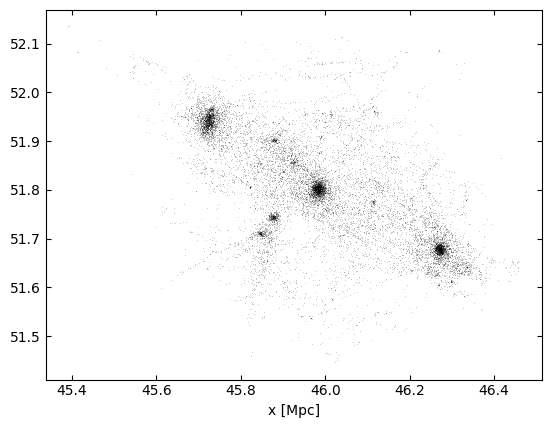

In [6]:
plt.plot(pos[:,0], pos[:,1], 'k,',alpha = 0.2)
plt.xlabel('x [Mpc]')

We also need to be careful to only consider haloes that are uncontaminated, without any low resoltuion particles in them. To do this we can use the additional data. Let's select only fof groups with no low res particles in their R200 (virial radius). Let's make the same plot, but cut to just uncontaminated subhaloes.

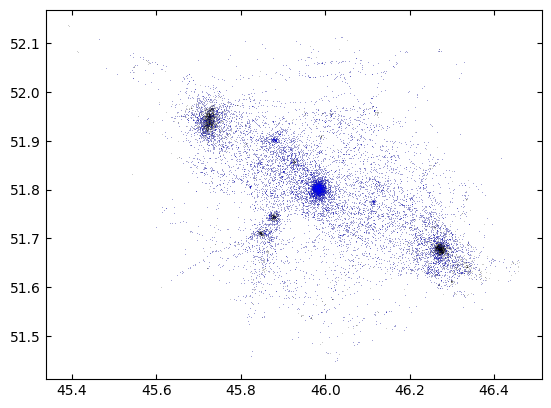

In [7]:
group_num = np.where(sf_add.data['fcnr'] > sf.data['frc2'])[0]
cut_sh = np.isin(sf.data['sgnr'],group_num)

plt.plot(pos[:,0], pos[:,1], 'k,',alpha = 0.2)
plt.plot(pos[cut_sh,0], pos[cut_sh,1], 'b,',alpha = 0.2)

Here you can see that many for the haloes are actually contaminated, so we probably don' trust their properties. For the rest of the file we can us both `group_num` and `cut_sh` to select uncontaminated haloes.

We can also look at the gas mass as a function of a haloes dark matter mass. Gas is type 0, DM type 1.

Text(0, 0.5, 'Gas mass [10^10 Msun]')

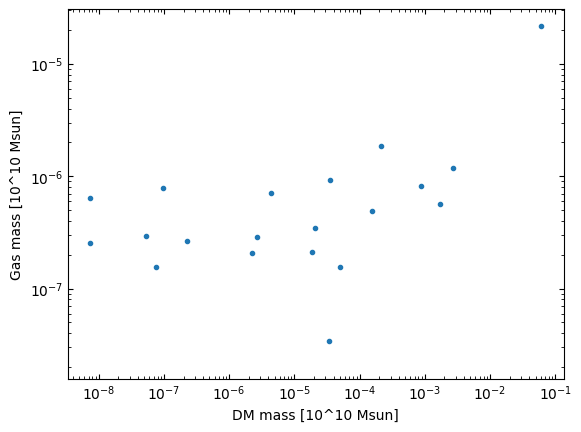

In [8]:
plt.plot(mass[cut_sh,1], mass[cut_sh,4],'.')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('DM mass [10^10 Msun]')
plt.ylabel('Gas mass [10^10 Msun]')

We see that in general more massive haloes, i.e. those with more DM, contain more gas.

Let's now also load in some of the simulation particle data. These data sets are much larger so be careful to only load the data you need. We'll begin by loading the particle positions and densities of the gas (particle type 0) for the most massive halo (halo 0). Also we will specify that the file type is hdf5, adn we want to use 'lazy laod'.

In [9]:
sn = ar.gadget_snap.gadget_snapshot(loc + halo + suffix + 'snapdir_127/snapshot_127',loadonlytype=[1], loadonlyhalo = 0, subfind = sf, hdf5=True, lazy_load=True)
print(sn.data.keys())

dict_keys(['pos', 'mass', 'id', 'vel', 'vol', 'type'])


Again, there are many different properties of the particles. Far more than we will use in this project. Let's begin by looking at their positions.

We can also visualise the spatial distribution of the DM (parttype 1). (There are a lot of data points to plot, so this will take a little while)

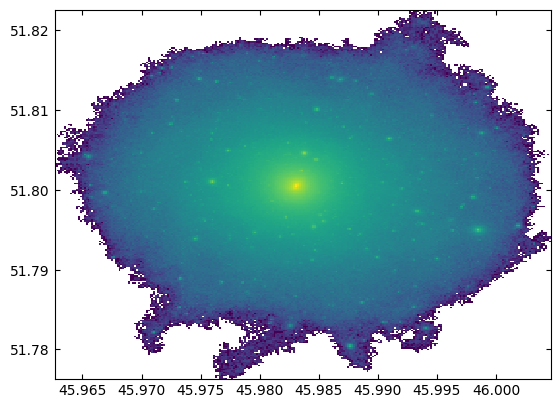

In [10]:
#sort data by density, so most dense gas sits on top of plot
import matplotlib as mpl

out = plt.hist2d(sn.data['pos'][:,0], sn.data['pos'][:,1], norm=mpl.colors.LogNorm(), bins = 256)


We also often want to find particles attached to different subhaloes within the fof group. There's a useful funciton in the arepo reader to help us with this.

In [11]:
sn.calc_sf_indizes(sf)

This will calcule the fof group number, and subhalo number for all particles. Let's first check we only have particle in fof group 0. The fof group numberis given oin the `'halo'` data.

In [12]:
print(len(sn.data['halo']), np.unique(sn.data['halo']))

8485923 [0]


Great, we have many elemts, but all within the same group number, which is what we expect. Now let's plot the distribution of DM particles for the 5 most massive subhaloes. The subhalo number is provided in the `'subhalo'` data/

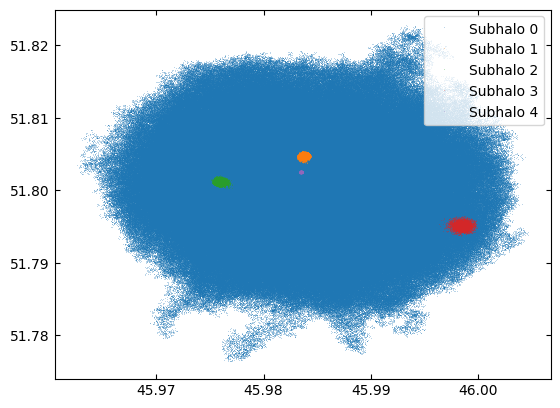

In [14]:
plt.figure()
for i in range(5):
    cut = sn.data['subhalo'] == i
    plt.plot(sn.data['pos'][cut,0], sn.data['pos'][cut,1], ',', alpha = 0.3, label = 'Subhalo %d'%i)

plt.legend(loc = 1)

Here we can see that subhalo 0 (the central) dominated the mass. But we also have subhaloes that can be identified as cound structures embedded within the main halo. You can visually see these haloes in the plot of the projected density.